### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 28 мая 2022, 08:30   
**Штраф за опоздание:** по 1 баллу за 24 часа задержки.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1053]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


In [1054]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=1, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = {}
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
        
        
        
    def __find_threshold(self, X, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        # Ваш код здесь
        
        ideal_col = None
        ideal_threshold = None

        # Check to see if there are at least 1 observations
        num_observations = y.size
        classes = np.arange(self.num_class)
        if num_observations <= 1:
            return ideal_col, ideal_threshold
        
        # Reshape y back to shape (y.size,)
        y = y.reshape(num_observations,)
        
        # Find the count of each class for use in Gini calc later
            # To avoid warning message + future issues:
                #  locked the numpy and python versions
                #  suppress warning with default warnings library (still runs without it)
        
        count_in_parent = [np.count_nonzero(y == c) for c in range(self.num_class)]

        # Set default value of best_gini to the gini impurity value of the parent node
            # Good article on gini impurity here: https://victorzhou.com/blog/gini-impurity/
        best_gini = 1.0 - sum((n / num_observations) ** 2 for n in count_in_parent)

        # Create a temp version of Y in the right shape for concatenating
        temp_y = y.reshape(y.shape[0],1)
        # Loop through the columns in X
        # Sort X and y by values of X in each column
            # Allows us to more easily find the ideal threshold
                # Better time complexity -> https://towardsdatascience.com/decision-tree-from-scratch-in-python-46e99dfea775
        for col in range(self.num_features):
            # Create a temp version of X[:,col] in the right shape for concatenating
            temp_X = X[:,col].reshape(num_observations,1)
            # Concatenate temp_X and temp_y
            all_data = np.concatenate((temp_X,temp_y), axis=1)
            # Sort the data using the colum with the feature/X value
            sorted_data = all_data[np.argsort(all_data[:,0])]
            # Split the data back into X and y, or threshold and classes values
            thresholds, obs_classes = np.array_split(sorted_data, 2, axis = 1)
            # Make sure observed classes are integers
            obs_classes = obs_classes.astype(int)
            
            # Keep track of how many of each class are going to each child node
                # Default is 0 of all classes to left and everything to right
            num_left = [0] * self.num_class
            num_right = count_in_parent.copy()
            # Loop through all observations in the node to efficiently find
            # ideal threshold and class that minimizes Gini impurities of child nodes
            for i in range(1, num_observations):
                class_ = obs_classes[i - 1][0]
                num_left[class_] += 1
                num_right[class_] -= 1
                if self.criterion == 'gini':
                    cur_left = 1.0 - sum((num_left[x] / i) ** 2 for x in range(self.num_class))
                    cur_right = 1.0 - sum((num_right[x] / (num_observations - i)) ** 2 
                                                          for x in range(self.num_class))
                elif self.criterion == 'entropy': 
                    cur_left = - sum((num_left[x] / i) * np.log(num_left[x] / i) if num_left[x] > 0 else 0 for x in range(self.num_class))
                    cur_right = - sum((num_right[x] / (num_observations - i)) * np.log(num_right[x] / (num_observations - i)) 
                                                          if num_left[x] > 0 else 0 for x in range(self.num_class))
                elif self.criterion == 'misclassify':
                    cur_left = 1.0 - max(num_left[x] / i for x in range(self.num_class))
                    cur_right = 1.0 - max((num_right[x] / 
                                                          (num_observations - i)) 
                                                          for x in range(self.num_class))
                gini = (i * cur_left + (num_observations - i) * cur_right) / num_observations
                # Go to the next i if i == i - 1
                    # Avoids making a split where two values are equal
                if thresholds[i][0] == thresholds[i - 1][0]:
                    continue
                # If gini is better than best_gini, re-assign ideals
                if gini < best_gini:
                    best_gini = gini
                    ideal_col = col
                    Q = gini
                    # Get the midpoint between i-th value and previous value
                    ideal_threshold = (thresholds[i][0] + thresholds[i - 1][0]) / 2
        if self.criterion == 'gini':
            cur = 1.0 - sum((count_in_parent[x] / num_observations) ** 2 for x in range(self.num_class))
            
        elif self.criterion == 'entropy': 
            cur = - sum((count_in_parent[x] / num_observations) * np.log(num_left[x] / num_observations) if num_left[x] > 0 else 0 for x in range(self.num_class))
            
        elif self.criterion == 'misclassify':
            cur = 1.0 - max(count_in_parent[x] / num_observations for x in range(self.num_class))
        if ideal_col not in self.feature_importances_:
            self.feature_importances_[ideal_col] = cur - Q
        else:
            self.feature_importances_[ideal_col] += cur - Q
        return ideal_col, ideal_threshold


    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        if depth >= self.max_depth or x.shape[0] < self.min_samples_split or np.unique(y).size == 1:
            temp = np.bincount(y)
            ans = temp.argmax()
            prob = temp / y.shape[0]
            # print(y, ans)
            self.tree[node_id] = [self.LEAF_TYPE, ans, prob]
        else:
            feature, val = self.__find_threshold(x, y)
            X_left, X_right, y_left, y_right = self.__div_samples(x, y, feature, val)
            # print(y_left.shape[0], y_right.shape[0])
            self.tree[node_id] = [self.NON_LEAF_TYPE, feature, val]
            self.__fit_node(X_left, y_left, 2 * node_id + 1, depth + 1) 
            self.__fit_node(X_right, y_right, 2 * node_id + 2, depth + 1) 
        
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.classes = np.unique(y)
        self.num_features = x.shape[1]
        self.num_class = self.classes.size
        
        self.__fit_node(x, y, 0, 0) 
        

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.feature_importances_
        
my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion = 'gini')

In [1056]:
a = np.arange(3)
b = np.asarray([1, 2, 3])
np.sum(b[a] ** 2)

14

In [1059]:
my_clf.tree

{0: [0, 9, 3.46],
 1: [0, 6, 1.58],
 3: [0, 12, 724.5],
 7: [1, 0, array([1.])],
 15: [0, 194, 22.5],
 31: [1, 0, array([1.])],
 32: [1, 1, array([0.11940299, 0.88059701])],
 16: [0, 5, 22834.0],
 33: [1, 1, array([0.2, 0.8])],
 34: [1, 0, array([1.])],
 8: [0, 1, 3.92],
 17: [1, 0, array([1.])],
 35: [1, 1, array([0.44642857, 0.55357143])],
 36: [1, 1, array([0.13636364, 0.86363636])],
 18: [1, 1, array([0., 1.])],
 37: [1, 1, array([0.375, 0.625])],
 38: [1, 0, array([0.68224299, 0.31775701])],
 4: [0, 10, 0.97],
 9: [1, 1, array([0., 1.])],
 19: [0, 129, 22.5],
 39: [1, 0, array([0.70748299, 0.29251701])],
 40: [1, 1, array([0.36842105, 0.63157895])],
 20: [0, 42, 18.0],
 41: [1, 0, array([0.875, 0.125])],
 42: [1, 1, array([0.03333333, 0.96666667])],
 10: [1, 2, array([0., 0., 1.])],
 21: [0, 38, 8.5],
 43: [1, 0, array([0.52, 0.48])],
 44: [1, 0, array([0.88, 0.12])],
 22: [0, 166, 1.75],
 45: [1, 0, array([0.65506329, 0.34493671])],
 46: [1, 0, array([0.83522727, 0.16477273])],
 

In [1060]:
X_test[9,:]

array([1.233e+01, 1.100e+00, 2.280e+00, 1.600e+01, 1.010e+02, 2.050e+00,
       1.090e+00, 6.300e-01, 4.100e-01, 3.270e+00, 1.250e+00, 1.670e+00,
       6.800e+02])

In [1061]:
y_pred=clf.predict(X_test)
y_pred, y_test

(array([1, 2, 0, 2, 0, 0, 0, 1, 2, 1, 2, 2, 1, 1, 0, 0, 1, 1]),
 array([1, 2, 0, 2, 0, 0, 0, 1, 2, 1, 2, 2, 1, 1, 0, 0, 1, 1]))

In [979]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2, max_depth=5)

In [1089]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [1058]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [1062]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

1.0
1.0


In [1063]:
my_clf.tree

{0: [0, 9, 3.46],
 1: [0, 6, 1.58],
 3: [0, 12, 724.5],
 7: [1, 0, array([1.])],
 15: [0, 194, 22.5],
 31: [1, 0, array([1.])],
 32: [1, 1, array([0.11940299, 0.88059701])],
 16: [0, 5, 22834.0],
 33: [1, 1, array([0.2, 0.8])],
 34: [1, 0, array([1.])],
 8: [0, 1, 3.92],
 17: [1, 0, array([1.])],
 35: [1, 1, array([0.44642857, 0.55357143])],
 36: [1, 1, array([0.13636364, 0.86363636])],
 18: [1, 1, array([0., 1.])],
 37: [1, 1, array([0.375, 0.625])],
 38: [1, 0, array([0.68224299, 0.31775701])],
 4: [0, 10, 0.97],
 9: [1, 1, array([0., 1.])],
 19: [0, 129, 22.5],
 39: [1, 0, array([0.70748299, 0.29251701])],
 40: [1, 1, array([0.36842105, 0.63157895])],
 20: [0, 42, 18.0],
 41: [1, 0, array([0.875, 0.125])],
 42: [1, 1, array([0.03333333, 0.96666667])],
 10: [1, 2, array([0., 0., 1.])],
 21: [0, 38, 8.5],
 43: [1, 0, array([0.52, 0.48])],
 44: [1, 0, array([0.88, 0.12])],
 22: [0, 166, 1.75],
 45: [1, 0, array([0.65506329, 0.34493671])],
 46: [1, 0, array([0.83522727, 0.16477273])],
 

In [1064]:
print(my_clf.get_feature_importance())

{30: 0.0600074788267565, 166: 0.039645458506090525, 106: 0.02567393263143386, 174: 0.045791621093795476, 194: 0.04365068168922223, 5: 0.32000000000000006, 38: 0.048204059513585557, 52: 0.03162463648846697, 215: 0.01860135508676025, 156: 0.014980795913853096, 163: 0.0516255630410139, 129: 0.03752714772426202, 42: 0.23548014773776532, 14: 0.009419043287790585, 9: 0.25357439793577974, 6: 0.3915103129179175, 12: 0.25602213541666663, 1: 0.1527777777777779, 10: 0.08493827160493828}


In [1065]:
my_clf.fit(X_train, y_train)
y_pred=my_clf.predict(X_test)
y_pred

array([1, 2, 0, 2, 0, 0, 0, 1, 2, 1, 2, 2, 1, 1, 0, 0, 1, 1])

In [1066]:
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
y_pred

array([1, 2, 0, 2, 0, 0, 0, 1, 2, 1, 2, 2, 1, 1, 0, 0, 1, 1])

In [1067]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

1.0
1.0


In [1068]:
wine.target.shape[0]

178

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [1104]:
%time clf.fit(X_train, y_train)

CPU times: user 6.87 ms, sys: 540 µs, total: 7.41 ms
Wall time: 3.99 ms


DecisionTreeClassifier(max_depth=5)

In [1105]:
%time my_clf.fit(X_train, y_train)

CPU times: user 39.2 ms, sys: 145 µs, total: 39.3 ms
Wall time: 35 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [1106]:
df = pd.read_csv('Speed Dating Data.csv', encoding='latin1')

In [1107]:
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [1108]:
print(df.iid.nunique())
df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)

551


In [1109]:
df.drop_duplicates(subset=['iid']).gender.value_counts()
df.drop_duplicates(subset=['iid']).condtn.value_counts()

2    386
1    165
Name: condtn, dtype: int64

In [1110]:
df = df.drop(['condtn'], axis=1)

In [1111]:
df = df.drop(['round'], axis=1)

In [1112]:
df = df.drop(['position', 'positin1'], axis=1)

In [1113]:
df = df.drop(['order'], axis=1)


In [1114]:
df = df.drop(['partner'], axis=1)

In [1115]:
df.shape

(8378, 187)

In [1116]:
df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], 
             axis=1)

<AxesSubplot:>

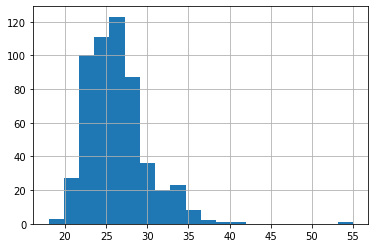

In [1117]:
df.drop_duplicates(subset=['iid']).age.hist(bins=20)

In [1118]:
df = df.dropna(subset=['age'])

In [1119]:
df = df.drop(['undergra'], axis=1)

In [1120]:
df = df.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1)

In [1121]:
df = df.drop(['expnum'], axis=1)

In [1122]:
df = df.drop(['from', 'zipcode'], axis=1)

In [1123]:
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)

In [1124]:
for i, group in df.groupby('field_cd'):
    print('=' * 10)
    print('Field Code {}'.format(i))
    print(group.field.unique())

Field Code 1.0
['Law' 'law' 'LAW' 'Law and Social Work'
 'Law and English Literature (J.D./Ph.D.)' 'Intellectual Property Law'
 'Law/Business']
Field Code 2.0
['Economics' 'Mathematics' 'Statistics' 'math' 'Mathematics, PhD' 'Stats'
 'math of finance' 'Math']
Field Code 3.0
['Psychology' 'Speech Language Pathology' 'Speech Languahe Pathology'
 'Educational Psychology' 'Organizational Psychology' 'psychology'
 'Communications' 'Sociology' 'psychology and english' 'theory'
 'Health policy' 'Clinical Psychology' 'Sociology and Education'
 'sociology' 'Anthropology/Education' 'speech pathology'
 'Speech Pathology' 'Anthropology' 'School Psychology' 'anthropology'
 'Counseling Psychology' 'African-American Studies/History']
Field Code 4.0
['Medicine' 'Art History/medicine'
 'Sociomedical Sciences- School of Public Health' 'Epidemiology'
 'GS Postbacc PreMed' 'medicine']
Field Code 5.0
['Operations Research' 'Mechanical Engineering' 'Engineering'
 'Electrical Engineering' 'Operations Researc

In [1125]:
df = df.drop(['field'], axis=1)

In [1126]:
df.shape

(8283, 147)

342

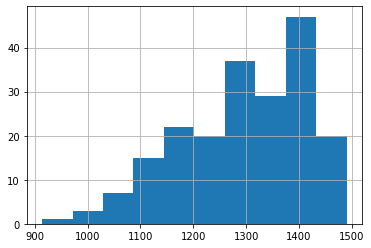

In [1127]:
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
df.drop_duplicates('iid').mn_sat.hist()
df.drop_duplicates('iid').mn_sat.isnull().sum()

In [1128]:
df = df.drop(['mn_sat'], axis=1)

310

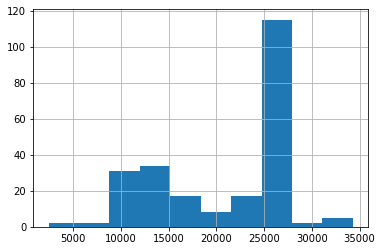

In [1129]:
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)
df.drop_duplicates('iid').tuition.hist()
df.drop_duplicates('iid').tuition.isnull().sum()

In [1130]:
df = df.drop(['race'], axis=1)

In [1131]:
df.drop_duplicates('iid').imprace.isnull().sum()
df.drop_duplicates('iid').imprelig.isnull().sum()

df = df.dropna(subset=['imprelig', 'imprace'])

In [1132]:
df.shape

(8267, 145)

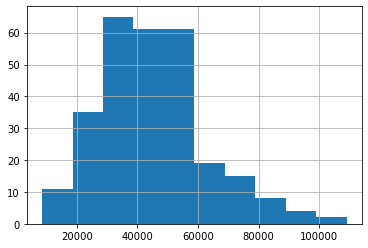

In [1133]:
# df = df.drop(['from', 'zipcode'], axis=1)
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)
df.drop_duplicates('iid').loc[:, 'income'].hist()
df.drop_duplicates('iid').loc[:, 'income'].isnull().sum()
df = df.drop(['income'], axis=1)

In [1134]:
df = df.dropna(subset=['date'])

In [1135]:
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)
df = df.drop(['career'], axis=1)

In [1136]:
feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 99)
temp.loc[idx, ]
idx = ((temp.wave >= 6) & (temp.wave <= 9))
temp.loc[idx, ]

df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)
df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

In [1137]:
feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 90) & (temp.totalsum != 0)
temp.loc[idx, ]
idx = ((temp.wave >= 6) & (temp.wave <= 9))
temp.loc[idx, ]
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)
df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100
df = df.drop(['temp_totalsum'], axis=1)

In [1138]:
df.shape

(8249, 143)

In [1139]:
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i), 
            'intel{}_1'.format(i), 'fun{}_1'.format(i), 
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    
    df = df.drop(feat, axis=1)

In [1140]:
df = df.drop(['wave'], axis=1)

In [1141]:

df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)
df_male = df_male.fillna(df_male.mean())                                 
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])
df_female = df_female.fillna(df_female.mean())\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)
                                   #.dropna()
        
df_female.columns = df_female.columns

In [1142]:
df_male

,iid,pid,match,int_corr,samerace,age,field_cd,tuition,imprace,imprelig,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
100,11,1.0,0,0.14,0,27.0,8.0,21534.444063,7.0,3.0,...,7.0,8.0,7.0,7.0,5.0,6.636364,7.13082,8.046563,7.029933,7.154102
101,11,2.0,0,0.29,1,27.0,8.0,21534.444063,7.0,3.0,...,7.0,8.0,7.0,7.0,5.0,6.636364,7.13082,8.046563,7.029933,7.154102
102,11,3.0,0,-0.24,1,27.0,8.0,21534.444063,7.0,3.0,...,7.0,8.0,7.0,7.0,5.0,6.636364,7.13082,8.046563,7.029933,7.154102
103,11,4.0,0,-0.18,1,27.0,8.0,21534.444063,7.0,3.0,...,7.0,8.0,7.0,7.0,5.0,6.636364,7.13082,8.046563,7.029933,7.154102
104,11,5.0,0,-0.43,1,27.0,8.0,21534.444063,7.0,3.0,...,7.0,8.0,7.0,7.0,5.0,6.636364,7.13082,8.046563,7.029933,7.154102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,526.0,0,0.64,0,25.0,18.0,21534.444063,1.0,1.0,...,8.0,5.0,7.0,6.0,7.0,9.000000,5.00000,9.000000,5.000000,6.000000
8374,552,527.0,0,0.71,0,25.0,18.0,21534.444063,1.0,1.0,...,8.0,5.0,7.0,6.0,7.0,9.000000,5.00000,9.000000,5.000000,6.000000
8375,552,528.0,0,-0.46,0,25.0,18.0,21534.444063,1.0,1.0,...,8.0,5.0,7.0,6.0,7.0,9.000000,5.00000,9.000000,5.000000,6.000000
8376,552,529.0,0,0.62,0,25.0,18.0,21534.444063,1.0,1.0,...,8.0,5.0,7.0,6.0,7.0,9.000000,5.00000,9.000000,5.000000,6.000000


In [1143]:
df_union = df_male.set_index('pid').join(df_female.set_index('iid'), lsuffix='f')

In [1144]:
df_union = df_union.fillna(df_union.mean())
df_union

,iid,match,int_corr,samerace,agef,field_cdf,tuitionf,impracef,impreligf,goalf,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
1.0,11,0,0.14,0,27.0,8.0,21534.444063,7.0,3.0,1.0,...,5.0,7.0,7.0,7.0,7.0,6.986301,8.013699,7.849315,7.246575,6.876712
1.0,12,0,0.54,0,22.0,1.0,21534.444063,1.0,1.0,1.0,...,5.0,7.0,7.0,7.0,7.0,6.986301,8.013699,7.849315,7.246575,6.876712
1.0,13,1,0.16,1,22.0,1.0,21534.444063,3.0,5.0,2.0,...,5.0,7.0,7.0,7.0,7.0,6.986301,8.013699,7.849315,7.246575,6.876712
1.0,14,1,0.61,0,23.0,1.0,21534.444063,1.0,1.0,2.0,...,5.0,7.0,7.0,7.0,7.0,6.986301,8.013699,7.849315,7.246575,6.876712
1.0,15,1,0.21,0,24.0,1.0,21534.444063,3.0,1.0,1.0,...,5.0,7.0,7.0,7.0,7.0,6.986301,8.013699,7.849315,7.246575,6.876712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530.0,548,0,0.23,0,30.0,8.0,21534.444063,8.0,8.0,1.0,...,6.0,9.0,5.0,7.0,5.0,3.000000,8.000000,8.000000,5.000000,5.000000
530.0,549,0,0.29,0,28.0,8.0,21534.444063,2.0,3.0,1.0,...,6.0,9.0,5.0,7.0,5.0,3.000000,8.000000,8.000000,5.000000,5.000000
530.0,550,0,-0.20,0,30.0,8.0,21534.444063,5.0,6.0,2.0,...,6.0,9.0,5.0,7.0,5.0,3.000000,8.000000,8.000000,5.000000,5.000000
530.0,551,0,-0.32,0,27.0,8.0,26019.000000,2.0,1.0,1.0,...,6.0,9.0,5.0,7.0,5.0,3.000000,8.000000,8.000000,5.000000,5.000000


In [1145]:
df[df['gender'] == 0].pid.unique().shape

(277,)

In [1146]:
df_female

,iid,pid,age,field_cd,tuition,imprace,imprelig,goal,date,go_out,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,11.0,21.0,1.0,20546.485075,2.0,4.0,2.0,7.0,1.0,...,5.000000,7.000000,7.000000,7.000000,7.000000,6.986301,8.013699,7.849315,7.246575,6.876712
10,2,11.0,24.0,1.0,20546.485075,2.0,5.0,1.0,5.0,1.0,...,7.000000,6.000000,9.000000,9.000000,4.000000,6.986301,8.013699,7.849315,7.246575,6.876712
20,3,11.0,25.0,2.0,20546.485075,8.0,4.0,6.0,3.0,1.0,...,7.365517,8.296552,8.317241,7.868966,7.427586,6.986301,8.013699,7.849315,7.246575,6.876712
30,4,11.0,23.0,1.0,20546.485075,1.0,1.0,1.0,5.0,1.0,...,6.000000,5.000000,6.000000,8.000000,5.000000,6.986301,8.013699,7.849315,7.246575,6.876712
40,5,11.0,21.0,1.0,20546.485075,8.0,1.0,2.0,4.0,1.0,...,4.000000,5.000000,10.000000,6.000000,10.000000,6.986301,8.013699,7.849315,7.246575,6.876712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7784,526,531.0,26.0,11.0,11311.000000,5.0,2.0,1.0,5.0,3.0,...,4.000000,3.000000,3.000000,7.000000,7.000000,2.000000,4.000000,4.000000,7.000000,7.000000
7806,527,531.0,24.0,11.0,15309.000000,5.0,5.0,1.0,4.0,3.0,...,7.365517,8.296552,8.317241,7.868966,7.427586,6.986301,8.013699,7.849315,7.246575,6.876712
7828,528,531.0,29.0,11.0,33585.000000,8.0,7.0,2.0,6.0,1.0,...,9.000000,8.000000,9.000000,10.000000,10.000000,9.000000,10.000000,9.000000,10.000000,10.000000
7850,529,531.0,22.0,5.0,26908.000000,4.0,1.0,2.0,4.0,1.0,...,6.000000,10.000000,7.000000,8.000000,7.000000,6.000000,9.000000,7.000000,8.000000,8.000000


In [1148]:
X = df_union.loc[:, df_union.columns != 'match'].to_numpy()
y = df_union['match'].to_numpy()

In [1149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [1162]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=5, criterion='misclassify')
my_clf.fit(X_train, y_train)

In [1161]:
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)) #gini

0.8433734939759037


In [1163]:
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)) #misclassify

0.8506024096385543


In [944]:
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)) #entropy

0.8361445783132531


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

Самая высокая точность получается при использовании критерия "ошибка классификации"

In [1153]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold

In [1154]:
acc_val = np.zeros((8, 5))

In [1165]:
for i in range(2, 10):
    for j in range(1, 6):
        my_clf = MyDecisionTreeClassifier(min_samples_split=j, max_depth=i, criterion='misclassify')
        my_clf.fit(X_train, y_train)
        acc_val[i-2, j-1] = accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

In [1156]:
acc_val

array([[0.83614458, 0.83614458, 0.83614458, 0.83614458, 0.83614458],
       [0.84578313, 0.84578313, 0.84578313, 0.84578313, 0.84578313],
       [0.84578313, 0.84578313, 0.84578313, 0.84578313, 0.84578313],
       [0.84337349, 0.84337349, 0.84337349, 0.84337349, 0.84337349],
       [0.84337349, 0.84337349, 0.84337349, 0.84337349, 0.84337349],
       [0.83614458, 0.83614458, 0.83614458, 0.83614458, 0.83614458],
       [0.83373494, 0.83373494, 0.83373494, 0.83373494, 0.83373494],
       [0.83373494, 0.83373494, 0.83373494, 0.8313253 , 0.8313253 ]])

Максимальная точность, которую удалось достичь, получилась 0.8795180722891566. Она достигается при максимальной глубине дерева - 7. Минимальное число объектов для сплита несильно влияет на точность.  

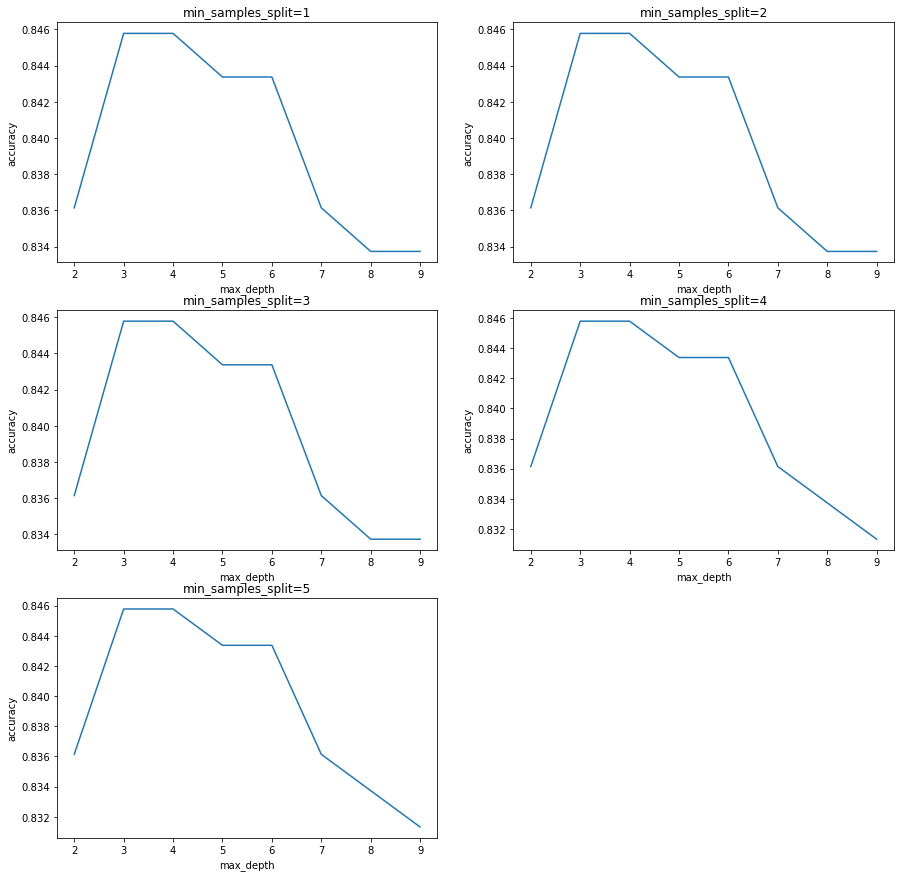

In [1157]:
point_x = np.arange(2, 10)
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
ax1 = fig.add_subplot(321)
ax1.set_ylabel('accuracy')
ax1.set_title('min_samples_split=1')

ax1.plot(point_x, acc_val.T[0]) # plotting by columns
ax1.set_xlabel('max_depth')

ax1 = fig.add_subplot(322)
ax1.set_ylabel('accuracy')
ax1.set_title('min_samples_split=2')
ax1.plot(point_x, acc_val.T[1]) # plotting by columns
ax1.set_xlabel('max_depth')

ax1 = fig.add_subplot(323)
ax1.set_ylabel('accuracy')
ax1.set_title('min_samples_split=3')
ax1.plot(point_x, acc_val.T[2]) # plotting by columns
ax1.set_xlabel('max_depth')

ax1 = fig.add_subplot(324)
ax1.set_ylabel('accuracy')
ax1.set_title('min_samples_split=4')
ax1.plot(point_x, acc_val.T[3]) # plotting by columns
ax1.set_xlabel('max_depth')

ax1 = fig.add_subplot(325)
ax1.set_ylabel('accuracy')
ax1.set_title('min_samples_split=5')
ax1.plot(point_x, acc_val.T[4]) # plotting by columns
ax1.set_xlabel('max_depth')

plt.show()

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [1158]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=5, criterion='gini')
my_clf.fit(X_train, y_train)

In [997]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.8626506024096385

In [1012]:
pop_feat = my_clf.get_feature_importance()
# pop_feat = dict(sorted(pop_feat.items(), key=lambda item: item[1], reverse=True))
# print(list(pop_feat.keys())[:10])
top = sorted(pop_feat, key=pop_feat.get, reverse=True)[:10]
print(top)
print(list(df_union.columns[top]))
# print(pop_feat)

[5, 42, 30, 163, 38, 174, 194, 166, 129, 52]
['field_cdf', 'attr1_sf', 'amb3_1f', 'shar', 'likef', 'attr3_s', 'attr4_2', 'met', 'pid', 'amb3_sf']


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

